In [595]:

from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
import pandas as pd
import numpy as np
import json
from ast import literal_eval
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### for getting user-item-rating data

In [173]:
data = []
with open('data/australian_users_items.json','r') as f:
    d = f.readline()
    idx = 0
    while d:
        data.append(literal_eval(d))
        d = f.readline()
        idx+=1
        if idx%200==0:
            print(idx,end=' ')
print(data[2])

200 400 600 800 1000 1200 1400 1600 1800 2000 2200 2400 2600 2800 3000 3200 3400 3600 3800 4000 4200 4400 4600 4800 5000 5200 5400 5600 5800 6000 6200 6400 6600 6800 7000 7200 7400 7600 7800 8000 8200 8400 8600 8800 9000 9200 9400 9600 9800 10000 10200 10400 10600 10800 11000 11200 11400 11600 11800 12000 12200 12400 12600 12800 13000 13200 13400 13600 13800 14000 14200 14400 14600 14800 15000 15200 15400 15600 15800 16000 16200 16400 16600 16800 17000 17200 17400 17600 17800 18000 18200 18400 18600 18800 19000 19200 19400 19600 19800 20000 20200 20400 20600 20800 21000 21200 21400 21600 21800 22000 22200 22400 22600 22800 23000 23200 23400 23600 23800 24000 24200 24400 24600 24800 25000 25200 25400 25600 25800 26000 26200 26400 26600 26800 27000 27200 27400 27600 27800 28000 28200 28400 28600 28800 29000 29200 29400 29600 29800 30000 30200 30400 30600 30800 31000 31200 31400 31600 31800 32000 32200 32400 32600 32800 33000 33200 33400 33600 33800 34000 34200 34400 34600 34800 35000 352

In [174]:
user_item_dict = {}
for d in tqdm(data):
    user_item_dict[d['user_id']] = []
    for i in d['items']:
        l=(i['item_id'],i['playtime_forever'],i['playtime_2weeks'])
        user_item_dict[d['user_id']].append(l)

100%|██████████| 88310/88310 [00:03<00:00, 24657.45it/s]


In [175]:
user_item_playtime = []
for k,v in tqdm(user_item_dict.items()):
    for i in v:
        user_item_playtime.append((k,i[0],i[1]))
user_item_playtime

  0%|          | 0/87626 [00:00<?, ?it/s]

100%|██████████| 87626/87626 [00:01<00:00, 47993.18it/s]


[('76561197970982479', '10', 6),
 ('76561197970982479', '20', 0),
 ('76561197970982479', '30', 7),
 ('76561197970982479', '40', 0),
 ('76561197970982479', '50', 0),
 ('76561197970982479', '60', 0),
 ('76561197970982479', '70', 0),
 ('76561197970982479', '130', 0),
 ('76561197970982479', '300', 4733),
 ('76561197970982479', '240', 1853),
 ('76561197970982479', '3830', 333),
 ('76561197970982479', '2630', 75),
 ('76561197970982479', '3900', 338),
 ('76561197970982479', '34440', 0),
 ('76561197970982479', '3920', 2),
 ('76561197970982479', '6400', 286),
 ('76561197970982479', '6910', 2685),
 ('76561197970982479', '7670', 633),
 ('76561197970982479', '409710', 0),
 ('76561197970982479', '220', 696),
 ('76561197970982479', '320', 0),
 ('76561197970982479', '340', 37),
 ('76561197970982479', '360', 0),
 ('76561197970982479', '380', 168),
 ('76561197970982479', '400', 173),
 ('76561197970982479', '420', 323),
 ('76561197970982479', '9340', 692),
 ('76561197970982479', '228200', 0),
 ('7656119

In [176]:
raw_data = pd.DataFrame(user_item_playtime,columns=['user','item','playtime'])
raw_data

,user,item,playtime
0,76561197970982479,10,6
1,76561197970982479,20,0
2,76561197970982479,30,7
3,76561197970982479,40,0
4,76561197970982479,50,0
...,...,...,...
5094077,76561198329548331,346330,0
5094078,76561198329548331,373330,0
5094079,76561198329548331,388490,3
5094080,76561198329548331,521570,4


### for getting review data

In [177]:
data = []
with open('data/australian_user_reviews.json','r') as f:
    d = f.readline()
    while d:
        d = literal_eval(d)
        for r in d['reviews']:
            data.append((d['user_id'],r['review'],r['recommend'],r['item_id']))
        d = f.readline()

In [178]:
raw_reviews = pd.DataFrame(data,columns=['user_id','review','recommend','item_id'])
reviewers = raw_reviews['user_id']
reviewed = raw_reviews['item_id']

In [179]:
reviewed_data = raw_data[raw_data['item'].isin(reviewed) & raw_data['user'].isin(reviewers)]
reviewed_data

,user,item,playtime
0,76561197970982479,10,6
1,76561197970982479,20,0
2,76561197970982479,30,7
3,76561197970982479,40,0
4,76561197970982479,50,0
...,...,...,...
5093508,76561198312638244,238010,284
5093509,76561198312638244,730,23
5093511,76561198312638244,362890,2184
5093513,76561198312638244,422970,0


### filtering nan and sparse data

In [180]:
item_stat_matrix = reviewed_data.groupby('item').agg({'playtime':['mean','std'],'user':['count']})
item_stat_matrix.dropna(axis=0,inplace=True)
item_stat_matrix = item_stat_matrix[item_stat_matrix[('playtime','std')]!=0]
item_stat_matrix = item_stat_matrix[item_stat_matrix[('user','count')]>10]
valid_items = item_stat_matrix.index
valid_items

Index(['10', '10090', '10130', '10140', '10150', '10180', '10220', '102500',
       '102600', '102700',
       ...
       '9900', '99100', '9930', '99300', '9940', '99400', '99700', '99810',
       '99900', '99910'],
      dtype='object', name='item', length=3148)

In [719]:
import pickle
with open('BI_rec_sys/data/item_stat_matrix.pkl','wb') as f:
    pickle.dump(item_stat_matrix,f)

In [181]:
user_stat_matrix = reviewed_data.groupby('user').agg({'playtime':['mean','std'],'item':['count']})
user_stat_matrix.dropna(axis=0,inplace=True)
user_stat_matrix = user_stat_matrix[user_stat_matrix[('playtime','std')]!=0]
user_stat_matrix = user_stat_matrix[user_stat_matrix[('item','count')]>10]
valid_users = user_stat_matrix.index
valid_users

Index(['--000--', '--ace--', '--ionex--', '-2SV-vuLB-Kg', '-Azsael-',
       '-Beave-', '-GM-Dragon', '-I_AM_EPIC-', '-Kenny', '-Mad-',
       ...
       'zukuta', 'zumpo', 'zunbae', 'zuzuga2003', 'zv_odd', 'zvanik',
       'zwanzigdrei', 'zynxgameth', 'zyr0n1c', 'zzoptimuszz'],
      dtype='object', name='user', length=21604)

In [182]:
filtered_reviewed_data = reviewed_data[reviewed_data['item'].isin(valid_items) & reviewed_data['user'].isin(valid_users)]
filtered_reviewed_data = filtered_reviewed_data[filtered_reviewed_data['playtime']!=0]
filtered_reviewed_data

,user,item,playtime
0,76561197970982479,10,6
2,76561197970982479,30,7
8,76561197970982479,300,4733
9,76561197970982479,240,1853
10,76561197970982479,3830,333
...,...,...,...
5093507,76561198312638244,286690,47
5093508,76561198312638244,238010,284
5093509,76561198312638244,730,23
5093511,76561198312638244,362890,2184


### final data

In [712]:
filtered_reviewed_data['playtime_log'] = filtered_reviewed_data['playtime'].apply(np.log)
filtered_reviewed_data

,user,item,playtime,playtime_log,rating,rating_norm
0,76561197970982479,10,6,1.791759,-0.939162,3.660500
2,76561197970982479,30,7,1.945910,-0.577758,3.922164
8,76561197970982479,300,4733,8.462315,1.597444,5.497058
9,76561197970982479,240,1853,7.524561,0.600656,4.775361
10,76561197970982479,3830,333,5.808142,0.451467,4.667345
...,...,...,...,...,...,...
5093507,76561198312638244,286690,47,3.850148,-1.046429,3.582836
5093508,76561198312638244,238010,284,5.648974,-0.057251,4.299023
5093509,76561198312638244,730,23,3.135494,-3.018409,2.155080
5093511,76561198312638244,362890,2184,7.688913,1.43489,5.379365


<Axes: ylabel='Frequency'>

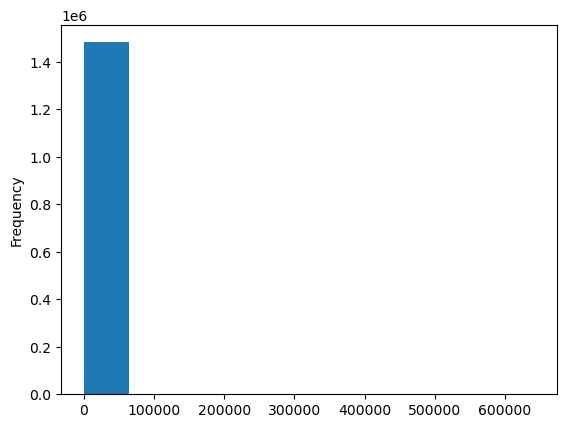

In [714]:
filtered_reviewed_data['playtime'].plot(kind='hist')

In [186]:
user_stat_matrix = filtered_reviewed_data.groupby('user').agg({'playtime_log':['mean','std'],'item':['count']})
item_stat_matrix = filtered_reviewed_data.groupby('item').agg({'playtime_log':['mean','std'],'user':['count']})

In [187]:
def playtime2rating(item_id, playtime):
    mean = item_stat_matrix.loc[item_id,('playtime_log','mean')]
    std = item_stat_matrix.loc[item_id,('playtime_log','std')]
    return (playtime - mean)/std

In [188]:
item_user_rating = filtered_reviewed_data.copy()
for i in tqdm(range(len(filtered_reviewed_data))):
    item_user_rating.iloc[i,2] = playtime2rating(filtered_reviewed_data.iloc[i,1],filtered_reviewed_data.iloc[i,2])
item_user_rating

100%|██████████| 1485717/1485717 [05:56<00:00, 4172.25it/s]


,user,item,playtime,playtime_log
0,76561197970982479,10,0.749296,1.791759
2,76561197970982479,30,1.751179,1.945910
8,76561197970982479,300,2316.432196,8.462315
9,76561197970982479,240,779.904513,7.524561
10,76561197970982479,3830,198.866960,5.808142
...,...,...,...,...
5093507,76561198312638244,286690,29.048996,3.850148
5093508,76561198312638244,238010,165.486750,5.648974
5093509,76561198312638244,730,7.437287,3.135494
5093511,76561198312638244,362890,1655.757380,7.688913


In [ ]:
raw_reviews['playtime'] = None
raw_reviews['playtime_log'] = None
raw_reviews

,user_id,review,recommend,item_id,playtime,playtime_log
0,76561197970982479,Simple yet with great replayability. In my opi...,True,1250,None,None
1,76561197970982479,It's unique and worth a playthrough.,True,22200,None,None
2,76561197970982479,Great atmosphere. The gunplay can be a bit chu...,True,43110,None,None
3,js41637,I know what you think when you see this title ...,True,251610,None,None
4,js41637,For a simple (it's actually not all that simpl...,True,227300,None,None
...,...,...,...,...,...,...
59300,76561198312638244,a must have classic from steam definitely wort...,True,70,None,None
59301,76561198312638244,this game is a perfect remake of the original ...,True,362890,None,None
59302,LydiaMorley,had so much fun plaing this and collecting res...,True,273110,None,None
59303,LydiaMorley,:D,True,730,None,None


In [ ]:
for i in tqdm(range(len(raw_reviews))):
    #v = filtered_reviewed_data[(filtered_reviewed_data['user']==raw_reviews.iloc[i,0]) & (filtered_reviewed_data['item']==raw_reviews.iloc[i,3])].iloc[0,2]
    uid = raw_reviews.iloc[i,0]
    if uid not in user_item_dict:
        continue
    for iid, ptime, _ in user_item_dict[raw_reviews.iloc[i,0]]:
        if iid == raw_reviews.iloc[i,3]:
            v = ptime
    if v==0:
        continue
    raw_reviews.iloc[i,4] = v
    raw_reviews.iloc[i,5] = np.log(v)
raw_reviews

100%|██████████| 59305/59305 [01:39<00:00, 594.84it/s] 


,user_id,review,recommend,item_id,playtime,playtime_log
0,76561197970982479,Simple yet with great replayability. In my opi...,True,1250,10006,9.21094
1,76561197970982479,It's unique and worth a playthrough.,True,22200,271,5.602119
2,76561197970982479,Great atmosphere. The gunplay can be a bit chu...,True,43110,834,6.726233
3,js41637,I know what you think when you see this title ...,True,251610,84,4.430817
4,js41637,For a simple (it's actually not all that simpl...,True,227300,551,6.311735
...,...,...,...,...,...,...
59300,76561198312638244,a must have classic from steam definitely wort...,True,70,1010,6.917706
59301,76561198312638244,this game is a perfect remake of the original ...,True,362890,2184,7.688913
59302,LydiaMorley,had so much fun plaing this and collecting res...,True,273110,2184,7.688913
59303,LydiaMorley,:D,True,730,2184,7.688913


In [ ]:
raw_reviews[raw_reviews['recommend']==True]

,user_id,review,recommend,item_id,playtime,playtime_log
0,76561197970982479,Simple yet with great replayability. In my opi...,True,1250,10006,9.21094
1,76561197970982479,It's unique and worth a playthrough.,True,22200,271,5.602119
2,76561197970982479,Great atmosphere. The gunplay can be a bit chu...,True,43110,834,6.726233
3,js41637,I know what you think when you see this title ...,True,251610,84,4.430817
4,js41637,For a simple (it's actually not all that simpl...,True,227300,551,6.311735
...,...,...,...,...,...,...
59300,76561198312638244,a must have classic from steam definitely wort...,True,70,1010,6.917706
59301,76561198312638244,this game is a perfect remake of the original ...,True,362890,2184,7.688913
59302,LydiaMorley,had so much fun plaing this and collecting res...,True,273110,2184,7.688913
59303,LydiaMorley,:D,True,730,2184,7.688913


In [ ]:
droped_raw_reviews = raw_reviews.dropna()
droped_raw_reviews=droped_raw_reviews[droped_raw_reviews['playtime_log']!=np.NINF]
droped_raw_reviews['playtime_log'].min()

0.0

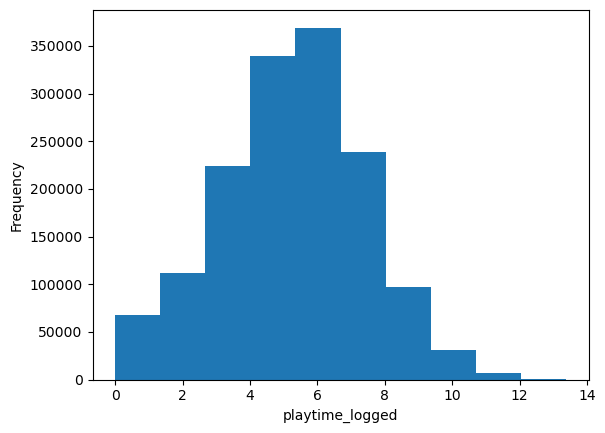

In [189]:
filtered_reviewed_data['playtime_log'].plot(kind='hist')
plt.xlabel('playtime_logged')
plt.show()

<Axes: ylabel='Frequency'>

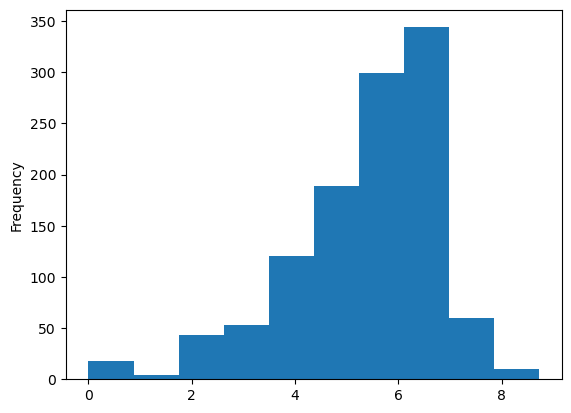

In [190]:
filtered_reviewed_data[filtered_reviewed_data['item']=='286690']['playtime_log'].plot(kind='hist')

<Axes: ylabel='Frequency'>

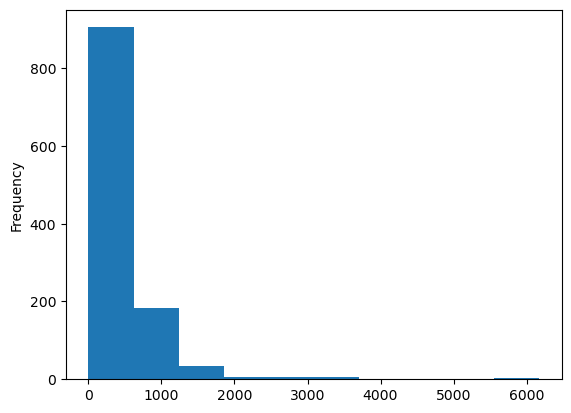

In [715]:
filtered_reviewed_data[filtered_reviewed_data['item']=='286690']['playtime'].plot(kind='hist')

In [191]:
def playtime2rating(item_id, playtime):
    mean = item_stat_matrix.loc[item_id,('playtime_log','mean')]
    std = item_stat_matrix.loc[item_id,('playtime_log','std')]
    return (playtime - mean)/std

In [192]:
filtered_reviewed_data['rating'] = None
for i in tqdm(range(len(filtered_reviewed_data))):
    filtered_reviewed_data.iloc[i,4] = playtime2rating(filtered_reviewed_data.iloc[i,1],filtered_reviewed_data.iloc[i,3])

100%|██████████| 1485717/1485717 [05:37<00:00, 4396.07it/s]


<Axes: ylabel='Frequency'>

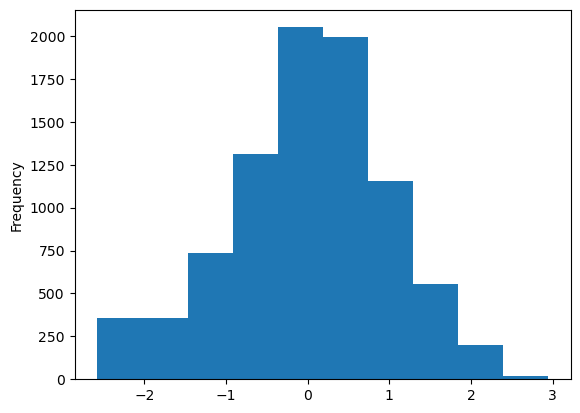

In [193]:
filtered_reviewed_data[filtered_reviewed_data['item']=='240']['rating'].plot(kind='hist')

In [721]:
iid_map

{'Lost Summoner Kitty': '761140',
 'Ironbound': '643980',
 'Real Pool 3D - Poolians': '670290',
 '弹炸人2222': '767400',
 'Battle Royale Trainer': '772540',
 'SNOW - All Access Basic Pass': '774276',
 'SNOW - All Access Pro Pass': '774277',
 'SNOW - All Access Legend Pass': '774278',
 'Army of Tentacles: (Not) A Cthulhu Dating Sim: Black GOAT of the Woods Edition': '770380',
 'Beach Rules': '768880',
 'Planetarium 2 - Zen Odyssey': '765320',
 'The first thrust of God': '773650',
 'SNOW - Starter Pack': '774271',
 'The first thrust of God - All Aircrafts': '773690',
 'SNOW - Lifetime Pack': '774279',
 'The Warrior Of Treasures': '768060',
 'RC Plane 3 - Canyon Scenario': '775880',
 'RC Plane 3 - F-53B': '775881',
 'DinoBlaster': '653960',
 'Carmageddon Max Pack': '282010',
 'Half-Life': '70',
 'Fallen Mage': '752360',
 'Vaporwave Simulator': '766850',
 'Underdone - Soundtrack': '754360',
 'Bitcoin Clicker': '716110',
 "Disciples II: Gallean's Return": '1640',
 'Disciples II: Rise of the El

In [194]:
min_val = filtered_reviewed_data['rating'].min()
max_val = filtered_reviewed_data['rating'].max()
d_val = max_val-min_val
def normalize_to_10(x):
    return (x-min_val)/(d_val)*10

In [195]:
filtered_reviewed_data['rating_norm'] = filtered_reviewed_data['rating'].apply(normalize_to_10)

In [196]:
filtered_reviewed_data.to_csv('data/processed_user_data_rating.csv')

In [253]:
data = []
with open('data/steam_games.json','r') as f:
    d = f.readline()
    while d:
        data.append(literal_eval(d))
        d = f.readline()

In [254]:
items = pd.DataFrame(data)
items = items[~items['id'].isna()]
items = items[~items['app_name'].isna()]
items = items[~items['price'].isna()]
items = items[~items['genres'].isna()]
items = items[~items['tags'].isna()]
items['price'] = items['price'].apply(lambda x: x if type(x)==float else 0)

In [255]:
iid_map = {}
iid_rmap = {}
for idx in range(len(items)):
    iid_map[items.iloc[idx,2]] = items.iloc[idx,12]
    iid_rmap[items.iloc[idx,12]] = items.iloc[idx,2]
tags = set()
for idx in range(len(items)):
    tags |= set(items.iloc[idx,6])

In [711]:
import pickle
with open(file = 'data/iid_map.pkl',mode='wb') as f:
    pickle.dump(iid_map,f)
with open(file = 'data/iid_rmap.pkl',mode='wb') as f:
    pickle.dump(iid_rmap,f)

In [256]:
multi_tags = ['4 Player Local', 'Asynchronous Multiplayer','Co-op', 'Co-op Campaign', 'Multiplayer', 'PvP']
def has_multi_tags(row):
    for t in multi_tags:
        if t in row['tags']:
            return True
    return False

In [257]:
multi_tagged_games = items[items.apply(has_multi_tags,axis=1)]
multi_tagged_games.head(3)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,670290,Poolians.com,Mostly Positive,NaN
27,Stainless Games Ltd,"[Action, Indie, Racing]",Carmageddon Max Pack,Carmageddon Max Pack,http://store.steampowered.com/app/282010/Carma...,1997-06-30,"[Racing, Action, Classic, Indie, Gore, 1990's,...",NaN,http://steamcommunity.com/app/282010/reviews/?...,"[Single-player, Multi-player, Steam Trading Ca...",9.99,False,282010,Stainless Games Ltd,Very Positive,NaN


In [677]:
filtered_items = items[['app_name','release_date','tags','id']].copy()

In [678]:
filtered_items.loc[32008,'release_date']='2021-01-01'
filtered_items.loc[31958,'release_date']='2021-01-01'
filtered_items.loc[13034,'release_date']='2021-01-01'
filtered_items['release_date'] = filtered_items['release_date'].fillna('2021-12-31')

In [679]:
filtered_items['release_date']=pd.to_datetime(filtered_items['release_date'])

In [680]:
reference_date = filtered_items['release_date'].max()
filtered_items['release_date_feature'] = (reference_date-filtered_items['release_date']).dt.days

In [681]:
filtered_items[filtered_items['release_date'].isna()]

,app_name,release_date,tags,id,release_date_feature


In [682]:
from sklearn.feature_extraction import FeatureHasher
hasher = FeatureHasher(n_features=15,input_type='string')
hashed_tags = hasher.transform(filtered_items['tags'].tolist()).toarray().astype(int)
hashed_tags

array([[ 0,  0,  0, ...,  0,  0, -2],
       [ 0, -1,  0, ..., -1,  0,  0],
       [ 0,  0,  0, ...,  0,  0, -1],
       ...,
       [ 0,  0,  0, ...,  0,  0, -2],
       [ 0,  0,  0, ...,  1,  0,  0],
       [-2,  0,  0, ...,  0,  0, -1]])

In [683]:
hashed_tags.shape

(27608, 20)

In [684]:
filtered_items = pd.concat((filtered_items.reset_index(drop=True),pd.DataFrame(hashed_tags)),axis=1)
filtered_items['p_type'] = None
#p_type :  0-solo 1-friend 2-couple 3-friends
filtered_items.head()

,app_name,release_date,tags,id,release_date_feature,0,1,2,3,4,...,11,12,13,14,15,16,17,18,19,p_type
0,Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",761140,1457,0,0,0,0,0,...,0,0,0,-1,0,0,0,0,-2,None
1,Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",643980,1457,0,-1,0,0,0,...,1,1,-1,1,2,0,-1,0,0,None
2,Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",670290,1621,0,0,0,0,0,...,0,0,0,-1,0,0,0,0,-1,None
3,弹炸人2222,2017-12-07,"[Action, Adventure, Casual]",767400,1485,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-1,None
4,Battle Royale Trainer,2018-01-04,"[Action, Adventure, Simulation, FPS, Shooter, ...",772540,1457,1,1,0,0,0,...,-1,0,0,0,1,1,0,0,0,None


In [685]:
filtered_items['multiplay'] = 0

In [686]:
multi_tags = ['4 Player Local', 'Asynchronous Multiplayer','Co-op', 'Co-op Campaign', 'Multiplayer', 'PvP','Split Screen','Massively Multiplayer','MOBA','MMORPG','Local Multiplayer','Local Co-Op','Competitive']
friend_tags = ['Asynchronous Multiplayer','PvP','Split Screen','Competitive']
couple_tags = ['Co-op', 'Co-op Campaign','Local Multiplayer','Local Co-Op','Split Screen','Online Co-Op']
multi_friends_tags = ['4 Player Local','Multiplayer','Massively Multiplayer','MOBA','MMORPG']
def has_multi_tags(row,multi_tags):
    for t in multi_tags:
        if t in row['tags']:
            return True
    return False

In [687]:
for idx in tqdm(range(len(filtered_items))):
    if has_multi_tags(filtered_items.iloc[idx,:],multi_tags):
        filtered_items.iloc[idx,21]=1
    if has_multi_tags(filtered_items.iloc[idx,:],couple_tags):
        filtered_items.iloc[idx,20]=2
    elif has_multi_tags(filtered_items.iloc[idx,:],friend_tags):
        filtered_items.iloc[idx,20]=1
    elif has_multi_tags(filtered_items.iloc[idx,:],multi_friends_tags):
        filtered_items.iloc[idx,20]=3
    else:
        filtered_items.iloc[idx,20]=0

  2%|▏         | 435/27608 [00:00<00:12, 2182.82it/s]

100%|██████████| 27608/27608 [00:11<00:00, 2301.99it/s]


In [688]:
def review_filter(row):
    if 'friend' in row['review']:
        return True
    return False

In [689]:
filterd_reviews = raw_reviews[raw_reviews.apply(review_filter,axis=1)]
for idx in range(len(filterd_reviews)):
    print(filterd_reviews.iloc[idx,1])

I know what you think when you see this title "Barbie Dreamhouse Party" but do not be intimidated by it's title, this is easily one of my GOTYs. You don't get any of that cliche game mechanics that all the latest games have, this is simply good core gameplay. Yes, you can't 360 noscope your friends, but what you can do is show them up with your bad ♥♥♥ dance moves and put them to shame as you show them what true fashion and color combinations are.I know this game says for kids but, this is easily for any age range and any age will have a blast playing this.8/8
At first, it looked to me that..."Wow, just another plain game... Minecraft Style I guess..."However, after playing it for almost 2 hours, I've realised that this game...Is nothing like Minecraft in terms on gaming content/adventure.If you've ever wished to get DayZ and want to get a first-hand experience of it, this game will be a great start!I do recommend that you guys play with a friend, and not Single Player (Just yet...)My 

In [690]:
review_friend = list(set(filterd_reviews['item_id'].values))

In [691]:
filtered_items.loc[filtered_items['id'].isin(review_friend),'p_type']=1

In [692]:
filtered_items['p_type'].value_counts()

0    23628
3     1758
2     1487
1      735
Name: p_type, dtype: int64

In [693]:
filtered_items['id'].isin(review_friend)

0        False
1        False
2        False
3        False
4        False
         ...  
27603    False
27604    False
27605    False
27606    False
27607    False
Name: id, Length: 27608, dtype: bool

<Axes: ylabel='Frequency'>

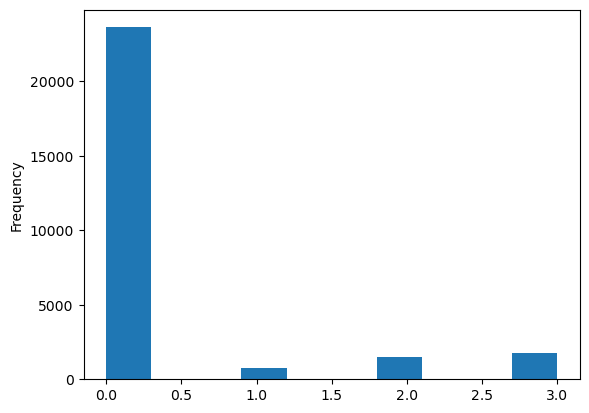

In [694]:
filtered_items['p_type'].plot(kind='hist')

In [695]:
scaler = StandardScaler()
scaled_date = scaler.fit_transform(filtered_items[['release_date_feature']])
filtered_items['release_date_feature'] = scaled_date

In [716]:
filtered_items.iloc[[27598],2]

27598    [Action, FPS, Shooter, Multiplayer, Singleplay...
Name: tags, dtype: object

In [697]:
processed_item_data = filtered_items.iloc[:,3:]
processed_item_data['app_name'] = filtered_items['app_name']
processed_item_data.to_csv('data/processed_item_data.csv')

In [698]:
processed_item_data

,id,release_date_feature,0,1,2,3,4,5,6,7,...,13,14,15,16,17,18,19,p_type,multiplay,app_name
0,761140,-0.789951,0,0,0,0,0,0,-1,0,...,0,-1,0,0,0,0,-2,0,0,Lost Summoner Kitty
1,643980,-0.789951,0,-1,0,0,0,-1,1,1,...,-1,1,2,0,-1,0,0,1,1,Ironbound
2,670290,-0.653418,0,0,0,0,0,0,0,0,...,0,-1,0,0,0,0,-1,3,1,Real Pool 3D - Poolians
3,767400,-0.766641,0,0,0,0,0,0,-1,0,...,0,1,0,0,0,0,-1,0,0,弹炸人2222
4,772540,-0.789951,1,1,0,0,0,0,-1,0,...,0,0,1,1,0,0,0,0,0,Battle Royale Trainer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27603,745400,-0.789951,0,0,0,0,0,0,-1,0,...,0,1,0,0,0,0,0,0,0,Kebab it Up!
27604,773640,-0.789951,0,0,0,0,0,0,0,0,...,0,-1,0,0,0,0,-2,0,0,Colony On Mars
27605,733530,-0.789951,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-2,0,0,LOGistICAL: South Africa
27606,610660,-0.789951,0,0,0,0,0,0,0,0,...,0,-1,0,0,1,0,0,0,0,Russian Roads


In [717]:
tags

{'1980s',
 "1990's",
 '2.5D',
 '2D',
 '2D Fighter',
 '3D Platformer',
 '3D Vision',
 '4 Player Local',
 '4X',
 '6DOF',
 'Abstract',
 'Action',
 'Action RPG',
 'Action-Adventure',
 'Adventure',
 'Agriculture',
 'Aliens',
 'Alternate History',
 'America',
 'Animation & Modeling',
 'Anime',
 'Arcade',
 'Arena Shooter',
 'Artificial Intelligence',
 'Assassin',
 'Asynchronous Multiplayer',
 'Atmospheric',
 'Audio Production',
 'Base Building',
 'Based On A Novel',
 'Basketball',
 'Batman',
 "Beat 'em up",
 'Benchmark',
 'Blood',
 'Board Game',
 'Bowling',
 'Building',
 'Bullet Hell',
 'Bullet Time',
 'CRPG',
 'Capitalism',
 'Card Game',
 'Cartoon',
 'Cartoony',
 'Casual',
 'Character Action Game',
 'Character Customization',
 'Chess',
 'Choices Matter',
 'Choose Your Own Adventure',
 'Cinematic',
 'City Builder',
 'Class-Based',
 'Classic',
 'Clicker',
 'Co-op',
 'Co-op Campaign',
 'Cold War',
 'Colorful',
 'Comedy',
 'Comic Book',
 'Competitive',
 'Conspiracy',
 'Controller',
 'Conversatio